In [1]:
import jax
import jax.numpy as jnp
from chewc.popgen import quick_haplo
from chewc.sp import SimParam
from chewc.trait import add_trait_a
from chewc.phenotype import set_pheno
from chewc.cross import make_cross
from chewc.population import combine_populations, Population
import matplotlib.pyplot as plt
from chewc.population import combine_populations, Population, subset_population # Add subset_population


--- JIT-compiling and running 2 replicates in parallel with vmap... ---
--- All Replicates Complete ---


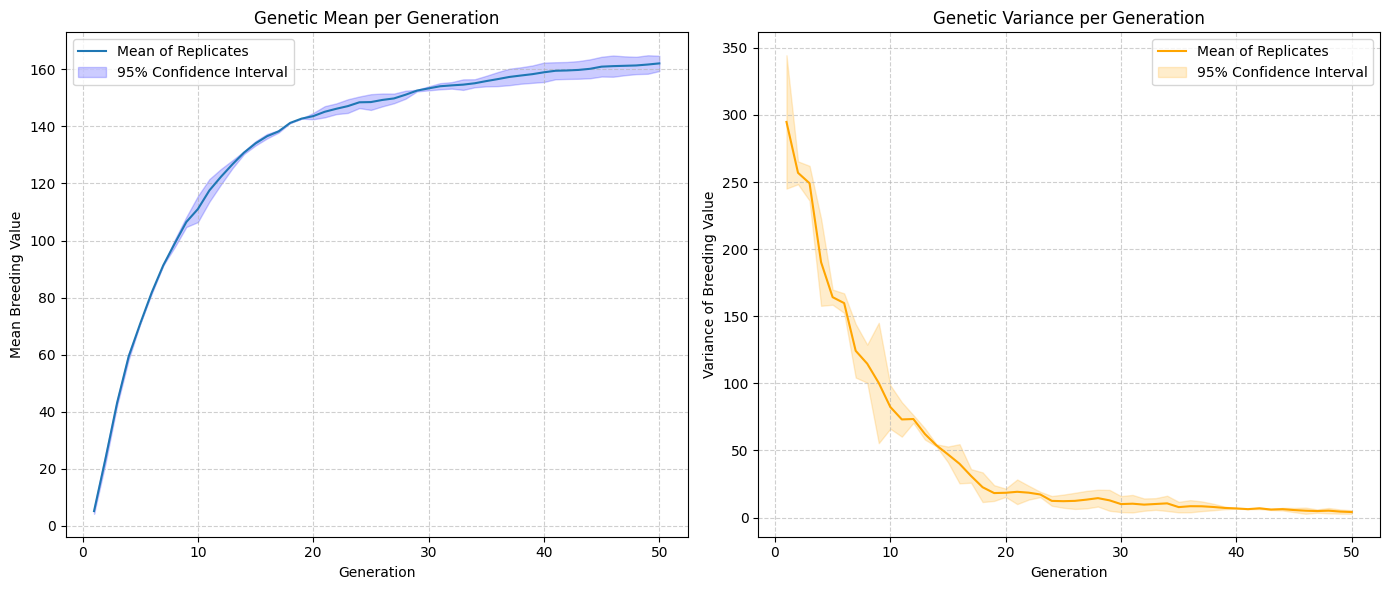

In [9]:
#KEEP

import jax
import jax.numpy as jnp
from jax import lax, vmap
import matplotlib.pyplot as plt
from functools import partial
import numpy as np

# Your chewc imports...
from chewc.popgen import msprime_pop
from chewc.sp import SimParam
from chewc.trait import add_trait_a
from chewc.phenotype import set_pheno, set_bv
from chewc.cross import make_cross
from chewc.population import Population

# ==================================================
# --- Simulation Parameters ---
# ==================================================
simulation_parameters = {
    "n_replicates": 2,
    "n_founder_ind": 100,
    "n_loci_per_chr": 1000,
    "n_chr": 5,
    "n_qtl_per_chr": 10,
    "trait_mean": jnp.array([0.0]),
    "trait_var": jnp.array([1.0]),
    "n_generations": 50,
    "population_size": 200,
    "n_select": 50,
    "h2" : jnp.array([.8]),
    "key": jax.random.PRNGKey(42)
}
simulation_parameters['max_pop_size'] = int(
    simulation_parameters['n_founder_ind'] + \
    simulation_parameters['population_size'] * simulation_parameters['n_generations']
)

# ==================================================
# --- JIT-compiled Functions ---
# ==================================================

# one_generation_step remains the same as before. It's the engine of our simulation.
@partial(jax.jit, static_argnames=('population_size', 'n_select', 'n_chr', 'ploidy'))
def one_generation_step(carry, gen_key, sp, population_size, n_select, n_chr, ploidy):
    # ... (function body is identical to the previous version) ...
    master_pop, next_id_start = carry
    current_gen_idx = jnp.max(master_pop.gen * master_pop.is_active)
    pheno_key, select_key, mate_key = jax.random.split(gen_key, 3)
    pheno_pop = set_pheno(
        key=pheno_key, pop=master_pop, traits=sp.traits,
        ploidy=ploidy, h2=simulation_parameters['h2']
    )
    is_selectable = (pheno_pop.gen == current_gen_idx) & pheno_pop.is_active
    selection_values = jnp.where(is_selectable, pheno_pop.pheno[:, 0], -jnp.inf)
    selected_iids = jnp.argsort(selection_values)[-n_select:]
    m_subkey1, m_subkey2 = jax.random.split(mate_key, 2)
    mothers = jax.random.choice(m_subkey1, selected_iids, shape=(population_size,))
    fathers = jax.random.choice(m_subkey2, selected_iids, shape=(population_size,))
    cross_plan = jnp.stack([mothers, fathers], axis=1)
    progeny_pop = make_cross(
        key=select_key, pop=pheno_pop, cross_plan=cross_plan,
        sp=sp, next_id_start=next_id_start
    )
    start_idx = jnp.sum(master_pop.is_active)
    updated_geno = lax.dynamic_update_slice(master_pop.geno, progeny_pop.geno, (start_idx, 0, 0, 0))
    updated_ibd = lax.dynamic_update_slice(master_pop.ibd, progeny_pop.ibd, (start_idx, 0, 0, 0))
    updated_id = lax.dynamic_update_slice(master_pop.id, progeny_pop.id, (start_idx,))
    updated_mother = lax.dynamic_update_slice(master_pop.mother, progeny_pop.mother, (start_idx,))
    updated_father = lax.dynamic_update_slice(master_pop.father, progeny_pop.father, (start_idx,))
    updated_sex = lax.dynamic_update_slice(master_pop.sex, progeny_pop.sex, (start_idx,))
    updated_gen = lax.dynamic_update_slice(master_pop.gen, progeny_pop.gen, (start_idx,))
    updated_is_active = lax.dynamic_update_slice(master_pop.is_active, progeny_pop.is_active, (start_idx,))
    updated_pop = master_pop.replace(
        geno=updated_geno, ibd=updated_ibd, id=updated_id,
        mother=updated_mother, father=updated_father, sex=updated_sex,
        gen=updated_gen, is_active=updated_is_active
    )
    final_pop = set_bv(updated_pop, sp.traits, ploidy)
    is_new_gen = final_pop.gen == (current_gen_idx + 1)
    new_gen_bvs = jnp.where(is_new_gen, final_pop.bv[:, 0], jnp.nan)
    genetic_mean = jnp.nanmean(new_gen_bvs)
    genetic_variance = jnp.nanvar(new_gen_bvs)
    new_carry = (final_pop, next_id_start + population_size)
    collected_metrics = (genetic_mean, genetic_variance)
    return new_carry, collected_metrics

def run_single_replicate(rep_key, founder_pop, sp):
    """Runs one full simulation replicate from a shared founder population."""
    n_generations = simulation_parameters["n_generations"]
    
    # The initial state for this replicate's scan
    initial_carry = (founder_pop, founder_pop.nInd)
    generation_keys = jax.random.split(rep_key, n_generations)

    # Run the scan over generations
    _, (genetic_means, genetic_variances) = lax.scan(
        lambda carry, key: one_generation_step(
            carry, key, sp,
            simulation_parameters['population_size'],
            simulation_parameters['n_select'],
            sp.n_chr,
            sp.ploidy
        ),
        initial_carry,
        generation_keys
    )
    return genetic_means, genetic_variances

# ==================================================
# --- Main Script Logic ---
# ==================================================

# --- 1. One-time Setup ---
master_key = simulation_parameters["key"]
founder_key, sp_key, rep_master_key = jax.random.split(master_key, 3)

# Step 1a: Create the single founder population using msprime
raw_founder_pop, genetic_map = msprime_pop(
    key=founder_key,
    n_ind=simulation_parameters["n_founder_ind"],
    n_loci_per_chr=simulation_parameters["n_loci_per_chr"],
    n_chr=simulation_parameters["n_chr"],
    max_pop_size=simulation_parameters['max_pop_size']
)

# Step 1b: Set up SimParam and add traits
sp = SimParam.from_founder_pop(raw_founder_pop, genetic_map)
sp = add_trait_a(
    key=sp_key, founder_pop=raw_founder_pop, sim_param=sp,
    n_qtl_per_chr=simulation_parameters["n_qtl_per_chr"],
    mean=simulation_parameters["trait_mean"],
    var=simulation_parameters["trait_var"]
)
n_traits = sp.n_traits
max_pop_size = simulation_parameters['max_pop_size']

# Step 1c: Create the final, correctly shaped founder pop to be reused
founder_pop = Population(
    geno=raw_founder_pop.geno, ibd=raw_founder_pop.ibd, id=raw_founder_pop.id,
    iid=raw_founder_pop.iid, mother=raw_founder_pop.mother, father=raw_founder_pop.father,
    sex=raw_founder_pop.sex, gen=raw_founder_pop.gen, is_active=raw_founder_pop.is_active,
    pheno=jnp.full((max_pop_size, n_traits), jnp.nan),
    fixEff=jnp.zeros(max_pop_size, dtype=jnp.float32),
    gv=jnp.full((max_pop_size, n_traits), jnp.nan),
    bv=jnp.full((max_pop_size, n_traits), jnp.nan),
    dd=jnp.full((max_pop_size, n_traits), jnp.nan),
    aa=jnp.full((max_pop_size, n_traits), jnp.nan),
    ebv=jnp.full((max_pop_size, n_traits), jnp.nan)
)

# --- 2. Run All Replicates in Parallel with vmap ---
n_replicates = simulation_parameters["n_replicates"]
replicate_keys = jax.random.split(rep_master_key, n_replicates)

print(f"--- JIT-compiling and running {n_replicates} replicates in parallel with vmap... ---")
# vmap broadcasts founder_pop and sp to all replicates thanks to `in_axes=(0, None, None)`
all_genetic_means, all_genetic_variances = vmap(
    run_single_replicate, in_axes=(0, None, None)
)(replicate_keys, founder_pop, sp)
print("--- All Replicates Complete ---")


# --- 3. Process and Plot Results (same as before) ---
# ... (plotting code remains identical) ...
mean_of_means = jnp.mean(all_genetic_means, axis=0)
std_of_means = jnp.std(all_genetic_means, axis=0)
se_of_means = std_of_means / jnp.sqrt(simulation_parameters["n_replicates"])
ci_means = 1.96 * se_of_means

mean_of_vars = jnp.mean(all_genetic_variances, axis=0)
std_of_vars = jnp.std(all_genetic_variances, axis=0)
se_of_vars = std_of_vars / jnp.sqrt(simulation_parameters["n_replicates"])
ci_vars = 1.96 * se_of_vars

plt.figure(figsize=(14, 6))
generations_axis = np.arange(1, simulation_parameters["n_generations"] + 1)
plt.subplot(1, 2, 1)
plt.plot(generations_axis, mean_of_means, label='Mean of Replicates')
plt.fill_between(generations_axis, mean_of_means - ci_means, mean_of_means + ci_means,
                 color='blue', alpha=0.2, label='95% Confidence Interval')
plt.title("Genetic Mean per Generation")
plt.xlabel("Generation")
plt.ylabel("Mean Breeding Value")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.subplot(1, 2, 2)
plt.plot(generations_axis, mean_of_vars, label='Mean of Replicates', color='orange')
plt.fill_between(generations_axis, mean_of_vars - ci_vars, mean_of_vars + ci_vars,
                 color='orange', alpha=0.2, label='95% Confidence Interval')
plt.title("Genetic Variance per Generation")
plt.xlabel("Generation")
plt.ylabel("Variance of Breeding Value")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()